In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import linear_model
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import svm

import re, string
from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train['comment_text']= train['comment_text'].apply(lambda x: x.replace('\n', ''))

In [5]:

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [6]:
print('Number of train data is ', len(train))
print('Number of test data is ', len(test))
print('Train-test split is ', round(len(train)/(len(train)+len(test)),2))


Number of train data is  159571
Number of test data is  153164
Train-test split is  0.51


## When I combine train and test set, train dataset are 50 % of test set. Therefore, this can be 50:50 train and test split.

# EDA

In [7]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
train.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself That is a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer Umm, theres no actual article for pros...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""And ... I really don't think you understand. ...",0,0,0,0,0,0


In [10]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
x=train.iloc[:,2:].sum()

rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


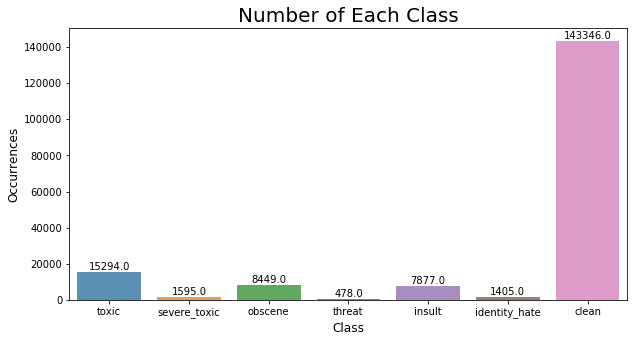

In [12]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(10,5))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number of Each Class", fontsize=20)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig("with_clean_comments.png")

In [13]:
x

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
clean            143346.0
dtype: float64

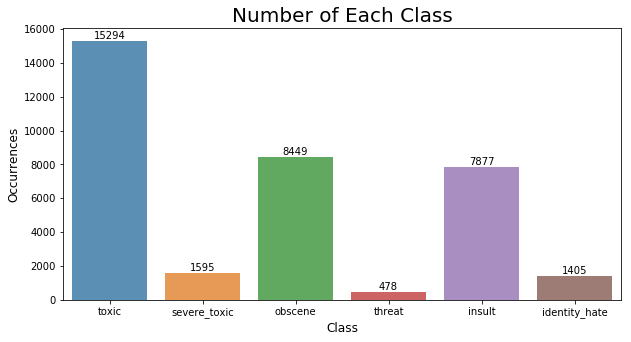

In [14]:
x=train.iloc[:,2:-1].sum()
#plot
plt.figure(figsize=(10,5))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Number of Each Class", fontsize=20)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Class', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig("without_clean_comments.png")

In [15]:
stopword=set(STOPWORDS)

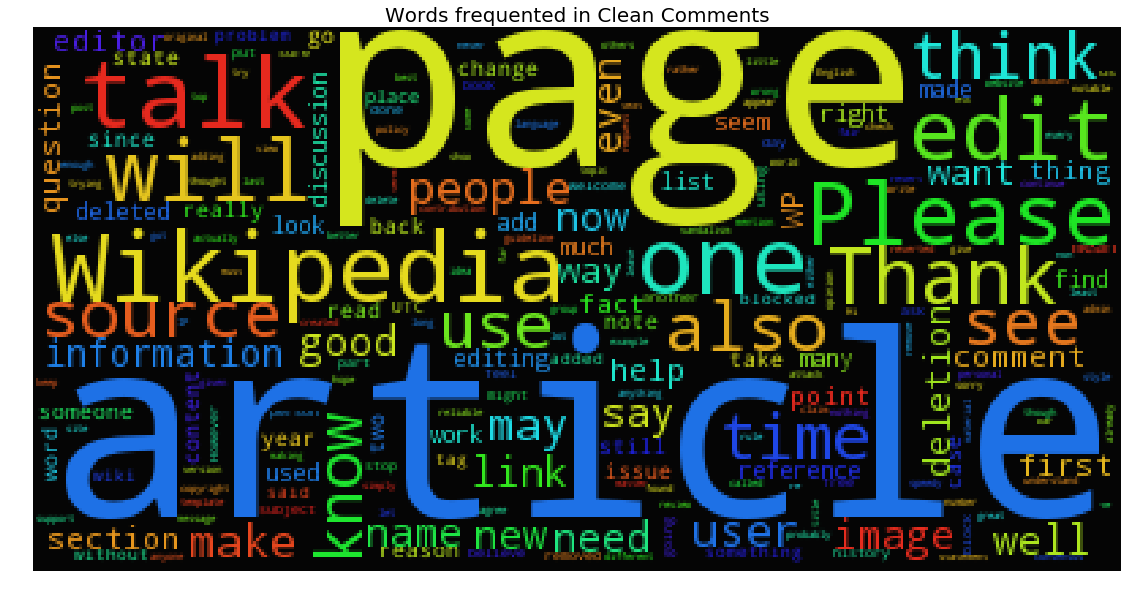

In [16]:
# wordcloud

clean=train[train.clean==True]
text = clean.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)

plt.savefig("words_clean");

''

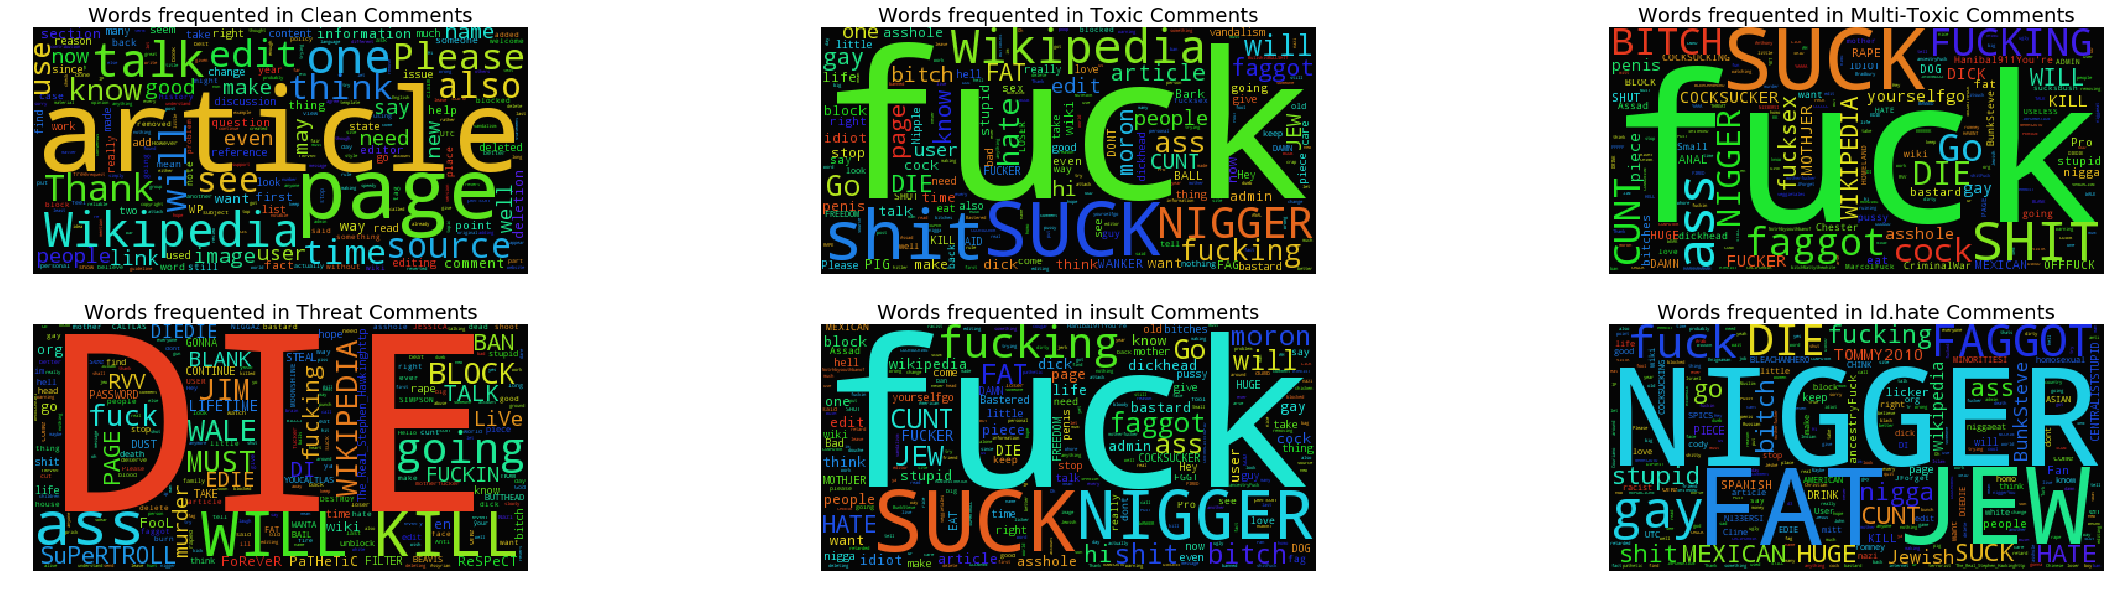

In [17]:
clean=train[train.clean==True]
text = clean.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(40,10))
plt.subplot(231)
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)

toxic=train[train.toxic==1]
text = toxic.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))

plt.subplot(232)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)

severe_toxic=train[train.severe_toxic==1]
text = severe_toxic.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))

plt.subplot(233)
plt.axis("off")
plt.title("Words frequented in Multi-Toxic Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)


threat=train[train.threat==1]
text = threat.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))

plt.subplot(234)
plt.axis("off")
plt.title("Words frequented in Threat Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)

insult=train[train.insult==1]
text = insult.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))

plt.subplot(235)
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)



identity_hate=train[train.identity_hate==1]
text = identity_hate.comment_text.values

wc= WordCloud(background_color="black",max_words=2000, stopwords=stopword)
wc.generate(" ".join(text))
plt.subplot(236)
plt.axis("off")
plt.title("Words frequented in Id.hate Comments", fontsize=20)
plt.imshow(wc, alpha=0.98)

;



### comment can fell into two or more categories.

In [19]:
x.value_counts

<bound method IndexOpsMixin.value_counts of toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64>

# Preprocessing

I just use train dataset to know how my model is working. 
I built different term-frequency inverse document frequency(TF-IDF) Vectorizer to check the frequency of words in each category and built models based on that.

In [20]:
vect_word = TfidfVectorizer(max_features=50000, stop_words='english', ngram_range=(1,2))


data = vect_word.fit_transform(train['comment_text'])


X = MaxAbsScaler().fit_transform(data)

target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

lr = linear_model.LogisticRegression(C=4,random_state = 42)
prd = np.zeros((X.shape[0],y.shape[1]))

for i,col in enumerate( y.columns):
    print('Building model for column:',col) 
    lr.fit(X,y[col])
    prd[:,i] = lr.predict_proba(X)[:,1]
    
    
for col in target_col:
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print(classification_report(y[col],pred))

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate
Column: toxic

Confusion matrix
 [[144231     46]
 [ 14438    856]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95    144277
          1       0.95      0.06      0.11     15294

avg / total       0.91      0.91      0.87    159571

Column: severe_toxic

Confusion matrix
 [[157305    671]
 [  1364    231]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    157976
          1       0.26      0.14      0.19      1595

avg / total       0.98      0.99      0.99    159571

Column: obscene

Confusion matrix
 [[150893    229]
 [  7776    673]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    151122
          1       0.75      0.08 

In [22]:
vect_word = TfidfVectorizer(max_features=50000, tokenizer=tokenize,\
                            stop_words='english', lowercase=True, analyzer='word', ngram_range=(1,2))


data = vect_word.fit_transform(train['comment_text'])


X = MaxAbsScaler().fit_transform(data)

target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

lr = linear_model.LogisticRegression(C=4,random_state = 42)
prd = np.zeros((X.shape[0],y.shape[1]))

for i,col in enumerate( y.columns):
    print('Building model for column:',col) 
    lr.fit(X,y[col])
    prd[:,i] = lr.predict_proba(X)[:,1]
    
    
for col in target_col:
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print(classification_report(y[col],pred))

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate
Column: toxic

Confusion matrix
 [[144217     60]
 [ 14338    956]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95    144277
          1       0.94      0.06      0.12     15294

avg / total       0.91      0.91      0.87    159571

Column: severe_toxic

Confusion matrix
 [[157198    778]
 [  1357    238]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    157976
          1       0.23      0.15      0.18      1595

avg / total       0.98      0.99      0.99    159571

Column: obscene

Confusion matrix
 [[150859    263]
 [  7696    753]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    151122
          1       0.74      0.09 

In [23]:
vect_word = TfidfVectorizer(max_features=50000, tokenizer=tokenize,\
                            lowercase=True, analyzer='char', stop_words='english',ngram_range=(1,5))

data = vect_word.fit_transform(train['comment_text'])


X = MaxAbsScaler().fit_transform(data)

target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]

lr = linear_model.LogisticRegression(C=4,random_state = 42)
prd = np.zeros((X.shape[0],y.shape[1]))

for i,col in enumerate( y.columns):
    print('Building model for column:',col) 
    lr.fit(X,y[col])
    prd[:,i] = lr.predict_proba(X)[:,1]
    
for col in target_col:
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print(classification_report(y[col],pred))

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate
Column: toxic

Confusion matrix
 [[144180     97]
 [ 14028   1266]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95    144277
          1       0.93      0.08      0.15     15294

avg / total       0.91      0.91      0.88    159571

Column: severe_toxic

Confusion matrix
 [[156917   1059]
 [  1291    304]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    157976
          1       0.22      0.19      0.21      1595

avg / total       0.98      0.99      0.98    159571

Column: obscene

Confusion matrix
 [[150764    358]
 [  7444   1005]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97    151122
          1       0.74      0.12 

In [24]:
subm = pd.read_csv('sample_submission.csv')

In [25]:
test[test['comment_text'].isnull()]

,id,comment_text


In [26]:
train['comment_text'].isnull().sum()

0

In [27]:
test['comment_text'].isnull().sum()

0

There are no no-value on train and test set.

In [28]:
df = pd.concat([train['comment_text'], test['comment_text']], axis=0)
df = df.fillna("unknown")
nrow_train = train.shape[0]


vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
data = vectorizer.fit_transform(df)

X = MaxAbsScaler().fit_transform(data)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))



loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = linear_model.LogisticRegression(C=9)
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('log loss:', log_loss(train[j], pred_train))
    loss.append(log_loss(train[j], pred_train))
    
print('mean column-wise log loss:', np.mean(loss))
    
    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
#submission.to_csv('submission.csv', index=False)


===Fit toxic
log loss: 0.0527097425109
===Fit severe_toxic
log loss: 0.0124787709775
===Fit obscene
log loss: 0.0264791425943
===Fit threat
log loss: 0.0029792513282
===Fit insult
log loss: 0.038314627597
===Fit identity_hate
log loss: 0.00921668718757
mean column-wise log loss: 0.0236963703659


In [29]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999885,0.058950,0.999717,0.013934,0.933525,0.339142
1,0000247867823ef7,0.001082,0.000566,0.000289,0.000324,0.002046,0.000458
2,00013b17ad220c46,0.011874,0.001045,0.004008,0.000278,0.006996,0.001063
3,00017563c3f7919a,0.000587,0.001243,0.001061,0.000178,0.002102,0.000037
4,00017695ad8997eb,0.004332,0.000873,0.001631,0.000994,0.001862,0.000506


In [30]:
submission.to_csv('submission.csv', index=False)

My score was 0.080

In [32]:
vectorizer = TfidfVectorizer(max_features=50000, tokenizer=tokenize,\
                            lowercase=True, analyzer='word', stop_words='english',ngram_range=(1,4))
data = vectorizer.fit_transform(df)


X = MaxAbsScaler().fit_transform(data)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))



loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = linear_model.LogisticRegression(C=9)
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('log loss:', log_loss(train[j], pred_train))
    loss.append(log_loss(train[j], pred_train))
    
print('mean column-wise log loss:', np.mean(loss))
    
    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('submission_word.csv', index=False)

===Fit toxic
log loss: 0.0439401024633
===Fit severe_toxic
log loss: 0.00951605253857
===Fit obscene
log loss: 0.0218981571947
===Fit threat
log loss: 0.00233663690999
===Fit insult
log loss: 0.0309029661748
===Fit identity_hate
log loss: 0.00749667438053
mean column-wise log loss: 0.0193484316103


When I add more conditions iin TfidfVectorizer, it does not improve. My score is 0.087

In [35]:



vectorizer = TfidfVectorizer(max_features=50000, tokenizer=tokenize,\
                            lowercase=True, analyzer='char', stop_words='english',ngram_range=(1,5))
data = vectorizer.fit_transform(df)



X = MaxAbsScaler().fit_transform(data)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))



loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = linear_model.LogisticRegression(C=9, n_jobs=3)
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('log loss:', log_loss(train[j], pred_train))
    loss.append(log_loss(train[j], pred_train))
    
print('mean column-wise log loss:', np.mean(loss))
    
    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('submission_char.csv', index=False)

===Fit toxic
log loss: 0.0169014332419
===Fit severe_toxic
log loss: 0.00305169769821
===Fit obscene
log loss: 0.00742089898402
===Fit threat
log loss: 0.000658411839042
===Fit insult
log loss: 0.0108692164044
===Fit identity_hate
log loss: 0.00216355589126
mean column-wise log loss: 0.00684420234313


In [84]:
# 0.118

In [31]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000, tokenizer=tokenize, ngram_range=(1,2))
data = vectorizer.fit_transform(df)

X = MaxAbsScaler().fit_transform(data)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))



loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = DecisionTreeClassifier()
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('log loss:', log_loss(train[j], pred_train))
    loss.append(log_loss(train[j], pred_train))
    
print('mean column-wise log loss:', np.mean(loss))
    
    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('submission3.csv', index=False)

===Fit toxic
log loss: 0.000564887198272
===Fit severe_toxic
log loss: 0.000300794055981
===Fit obscene
log loss: 0.000449043347794
===Fit threat
log loss: 5.54048938131e-05
===Fit insult
log loss: 0.000557198528079
===Fit identity_hate
log loss: 0.000188704354702
mean column-wise log loss: 0.000352672063107


In [90]:
#1.407  -- too overfit

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000, tokenizer=tokenize, ngram_range=(1,2))
data = vectorizer.fit_transform(df)

X = MaxAbsScaler().fit_transform(data)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))



loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = ensemble.RandomForestClassifier()
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('log loss:', log_loss(train[j], pred_train))
    loss.append(log_loss(train[j], pred_train))
    
print('mean column-wise log loss:', np.mean(loss))
    
    
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = col)], axis=1)
submission.to_csv('submission4.csv', index=False)

===Fit toxic
log loss: 0.0336536127243
===Fit severe_toxic
log loss: 0.0065007101496
===Fit obscene
log loss: 0.0169441476388
===Fit threat
log loss: 0.00208268317791
===Fit insult
log loss: 0.0210085628073
===Fit identity_hate
log loss: 0.00577717959711
mean column-wise log loss: 0.0143278160158


# 0.176 --> Using other model does not improve my model.